In [1]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve
using ForwardDiff: jacobian, derivative

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
N = 3 # number of firms per cohort
cohorts = (N, N) # cohorts
K = length(cohorts) # number of cohorts
q = range(2.0, 3.0, length = K)
f = fill(1/(N+1)^K, (N+1)^K); # awareness set distribution

In [4]:
params = (cohorts = cohorts, Γ_bar = 1.0, Ω = 1.0, q = q, σ = 5.0, κ = 1.5, mc = 1.0, α = -0.5)

(cohorts = (3, 3), Γ_bar = 1.0, Ω = 1.0, q = 2.0:1.0:3.0, σ = 5.0, κ = 1.5, mc = 1.0, α = -0.5)

# Demand function with 2-type firms

In [5]:
b = 1 # the cohort firm i belongs to
p = fill(1.0, K); # K-vector of prices

### With logit demand with awareness set

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Assume demand on $u_j = \alpha p_i + q_i + \epsilon_{ij}$. Given the awareness set $n$, firm $i$ on $b$ type faces market share
$$
y_i (p_i, p_{-i}, n) = \frac{\exp(\alpha p_i + q_b)}{ N_L \exp (\alpha p_L + q_L) + N_H \exp (\alpha p_H + q_H)  - \exp(\alpha p_{b} + q_{b}) +\exp(\alpha p_i + q_{b})  }
$$
Since the probability of being selected as one of the $n_b$ firms out of $N_b$ firms is $n_b / N_b$ (Polyr urn), the demand function is
$$
y_i (p_i, p_{-i}) = \sum_{n; n_b > 0}  f(n) \dfrac{n_b}{N_b} y_i (p_i, p_{-i}, n)
$$
Assume constant marginal cost,$c$, so that profits are
$$
\pi_i (p_i, p_{-i}) = (p_i - c) y_i (p_i, p_{-i})
$$

In [6]:
# Demand function with logit demand
# p_i: the price of product of firm i (can be different from p[b])
# b: the cohort firm i belongs to
# p: NK-vector of prices across firms
# f: awareness set distribution
# params: model parameters
# n: awareness set
function share(p_i, b, p, f, params, n)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ, α = params
    exponentials = exp.(α*p.+q)
    exponentials_sum = sum(n .* exponentials) # summation by firms in awareness set
    numerator = exp(α*p_i + q[b])
    return numerator / (exponentials_sum - exponentials[b] + numerator)
end

function demand(p_i, b, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ = params
    K = length(cohorts)
    f = reshape(f, Tuple(fill(0:N, K)))
    demand_value = 0

    for n in CartesianIndices(f)
        if (n[b] > 0)
            demand_value += (n[b] / cohorts[b]) * f[n] * share(p_i, b, p, f, params, Tuple(n))
        end
    end
    return demand_value
end

profit(p_i, b, p, f, params) = (p_i - params.mc) * demand(p_i, b, p, f, params)
profit_derivative(p_i, b, p, f, params) = derivative(p_i -> profit(p_i, b, p, f, params), p_i)

profit_derivative (generic function with 1 method)

## Plots

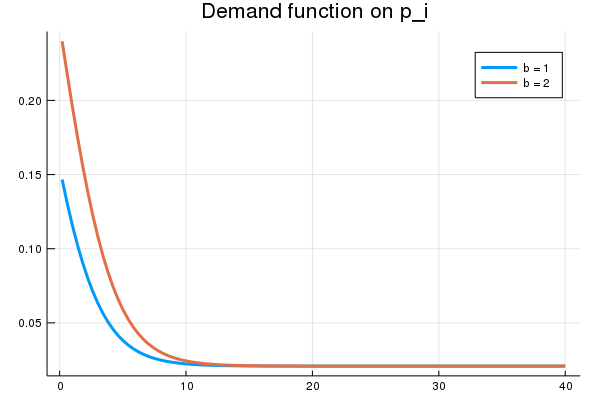

In [7]:
# plot the demand function
plot(range(0.2,stop=40.0,length=100), (b -> (p_i -> demand(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Demand function on p_i")

In [8]:
# confirm that the demand function is decreasing in price
@assert all(diff((p_i -> demand(p_i, b, p, f, params)).(1:100)) .<= 0)

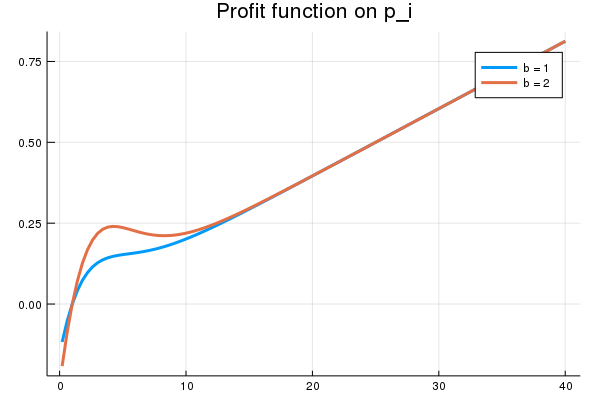

In [9]:
# plot the profit function
plot(range(0.2,stop=40.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i")

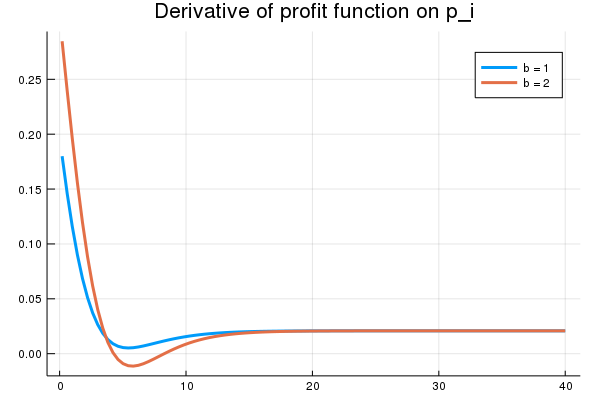

In [10]:
# plot the profit derivative function
plot(range(0.2,stop=40.0,length=100), (b -> (p_i -> profit_derivative(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Derivative of profit function on p_i")

# Nash equilibria

In [11]:
function D_p(p, f, params)
    # K-vector of cohorts where ith element represents ith firms' cohort
    bs = 1:length(params.cohorts)
    # return the vector of derivatives
    return [profit_derivative(p[b], bs[b], p, f, params) for b in eachindex(p)]
end

function nash_equilibrium(f, params; autodiff=:forward, iv = fill(params.mc, length(params.cohorts)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = autodiff)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [12]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 4.3286859014082175
 4.678697052025984 

## Plots

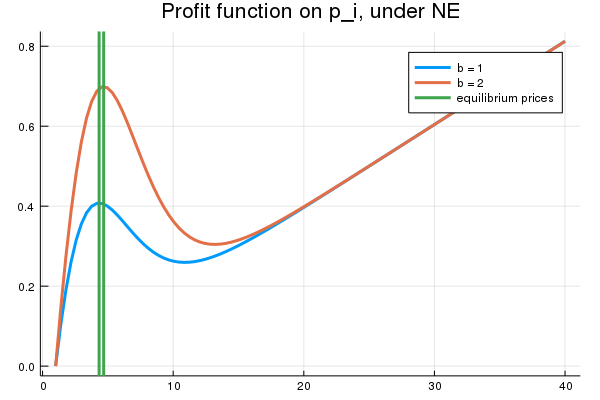

In [13]:
plot(range(1.0,stop=40.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")

Notice that the equilbria found from the first order condition are not Nash equilbria -- firms are strictly better off when they increase the price extremely. This is due to the introduction of awareness sets; firms can expolit their monopoly power when they are the only firms awared.

The monopoly power can be 1) removed when at least one firm from each type is awared or 2) alleviated when there are larger number of firms available:

## Plots (at least one firm from each type is awared)

In [14]:
f = fill(0, (N+1)^K);
f = reshape(f, Tuple(fill(0:N, K)))
for f_i in CartesianIndices(f)
    # awared only if at least one firm from each type is awared
    f[f_i] = (f_i[1] > 0 && f_i[2] > 0) ? 1 : 0 
end
f /= sum(f)
f # awareness set distribution where at least one firm from each type is awared

OffsetArray(::Array{Float64,2}, 0:3, 0:3) with eltype Float64 with indices 0:3×0:3:
 0.0  0.0       0.0       0.0     
 0.0  0.111111  0.111111  0.111111
 0.0  0.111111  0.111111  0.111111
 0.0  0.111111  0.111111  0.111111

In [15]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 3.4837509202662815
 4.133959295719653 

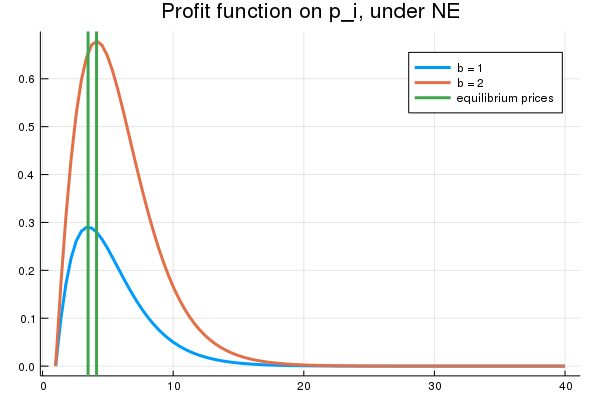

In [16]:
plot(range(1.0,stop=40.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")

## Plots (with more firms for each type)

In [17]:
N = 10 # number of firms per cohort
cohorts = (N, N) # cohorts
f = fill(1/(N+1)^K, (N+1)^K); # awareness set distribution
params = merge(params, (cohorts = cohorts, ))

(cohorts = (10, 10), Γ_bar = 1.0, Ω = 1.0, q = 2.0:1.0:3.0, σ = 5.0, κ = 1.5, mc = 1.0, α = -0.5)

In [18]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 3.288559987750306
 3.419882290924676

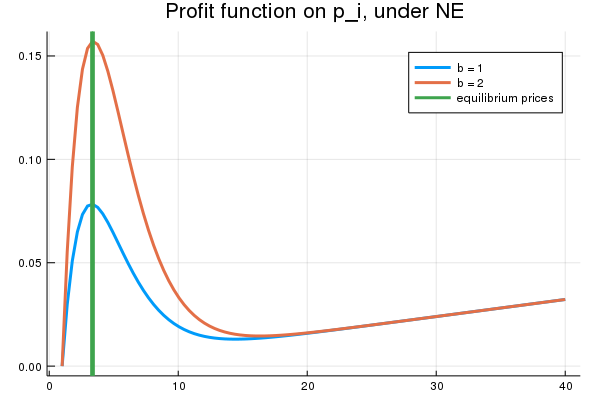

In [19]:

plot(range(1.0,stop=40.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")